This is the notebook to run the GRU network. It starts with a preprocessed file with p2_calib being the value to predict, and int_deliv_inv_ub and calib_time being the best values to use. It's important to note that at this point, some of the lumi measurements are taken a bit far from the calibration times. this can be seen by the difference between the lumi-section time and the calib_time values. The best data probably just consistents of the points where these are close.

All data is in its original units.

Also, I'm running this in the Python 3.7.1 Kernel

In [1]:
#import the stuff
import pandas as pd #dataframes etc
import matplotlib.pyplot as plt #plotting
import numpy as np
from sklearn import preprocessing
from common.utils import TimeSeriesTensor, create_evaluation_df, mape, scale_shrinker

In [2]:
#load the data
test = pd.read_csv('../data/test_diff.csv', index_col=0)
valid = pd.read_csv('../data/valid_diff.csv', index_col=0)
train = pd.read_csv('../data/train_diff.csv', index_col=0)
#set index to datetime periods
#test.index = pd.to_datetime(test.index).to_period('H')
#valid.index = pd.to_datetime(valid.index).to_period('H')
#train.index = pd.to_datetime(train.index).to_period('H')
#set index to datetime
test.index = pd.to_datetime(test.index)
valid.index = pd.to_datetime(valid.index)
train.index = pd.to_datetime(train.index)
train.head()

,p2,int_deliv_inv_ub
2018-06-22 18:39:44,0.000039,6637.554405
2018-06-22 19:39:44,-0.000029,6028.089283
2018-06-22 20:39:44,0.000052,4197.100697
2018-06-22 21:39:44,0.000066,6308.041306
2018-06-22 22:39:44,0.000060,6308.041313


In [3]:
#now we will scale the data
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = StandardScaler()
y_scaler = StandardScaler() #we'll use the y-scaler later
y_scaler.fit(train[['p2']])
train[['p2', 'int_deliv_inv_ub']] = scaler.fit_transform(train)
train.describe()


,p2,int_deliv_inv_ub
count,1.981000e+03,1.981000e+03
mean,1.675703e-17,6.755491e-16
std,1.000252e+00,1.000252e+00
min,-3.959721e+00,-9.459218e-01
25%,-3.061145e-01,-9.456447e-01
50%,2.263512e-01,-2.924884e-01
75%,6.040580e-01,8.534767e-01
max,2.018919e+00,2.202867e+00


In [4]:
valid[['p2', 'int_deliv_inv_ub']] = scaler.transform(valid)
valid.describe()

,p2,int_deliv_inv_ub
count,813.000000,813.000000
mean,-0.015470,-0.016140
std,1.111188,1.000044
min,-4.168876,-0.945922
25%,-0.318478,-0.945922
50%,0.208617,-0.361363
75%,0.645773,0.906174
max,3.149370,2.170162


In [5]:
test[['p2', 'int_deliv_inv_ub']] = scaler.transform(test)
test.describe()

,p2,int_deliv_inv_ub
count,839.000000,839.000000
mean,0.084151,-0.944355
std,0.254370,0.012042
min,-0.610920,-0.945922
25%,-0.081761,-0.945922
50%,0.078562,-0.945922
75%,0.236518,-0.945921
max,1.576933,-0.821779


In [6]:
#number of lag variables and horizon (these are just some starting choices)
T = 10 #the past N hours to study
HORIZON = 1 #predict the next N hours

#sample tensor structure
tensor_structure = {'X':(range(-T+1, 1), ['p2', 'int_deliv_inv_ub'])}

#training tensor
train_input = TimeSeriesTensor(
    dataset=train,
    target="p2",
    H=HORIZON,
    tensor_structure=tensor_structure,
    freq="H", #hours
    drop_incomplete=True, 
)

#validation tensor
valid_inputs = TimeSeriesTensor(valid, "p2", HORIZON, tensor_structure)
print(train_input['X'][0])
print(train_input['target'][0])
train_input['target'].shape
train_input['X'].shape

#print(valid_inputs['X'][0])
#print(valid_inputs['target'][0])

[[ 0.1102464  -0.94552794]
 [-0.03826301 -0.94556411]
 [ 0.13761956 -0.94567274]
 [ 0.16853182 -0.9455475 ]
 [ 0.1554102  -0.9455475 ]
 [ 0.01601738 -0.9455475 ]
 [ 0.22536023 -0.94581004]
 [ 0.20284247 -0.94591118]
 [ 0.24617286 -0.94592177]
 [ 0.09996933 -0.94592177]]
[0.17279839]


(1971, 10, 2)

In [7]:
#now we bring in the keras tensorflow model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.losses import MeanSquaredLogarithmicError, MeanSquaredError
from tensorflow.keras.utils import plot_model

#from keras_visualizer import visualizer

from math import pow, floor
import time

In [8]:
# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.00001
    drop = 0.5
    epochs_drop = 200
    lrate = initial_lrate * pow(drop, floor((1+epoch)/epochs_drop))
    return initial_lrate

def my_loss_fn(y_true, y_pred):
    return abs((y_true - y_pred) ** 3.0)

In [25]:
train_input["X"][0]

array([[ 0.1102464 , -0.94552794],
       [-0.03826301, -0.94556411],
       [ 0.13761956, -0.94567274],
       [ 0.16853182, -0.9455475 ],
       [ 0.1554102 , -0.9455475 ],
       [ 0.01601738, -0.9455475 ],
       [ 0.22536023, -0.94581004],
       [ 0.20284247, -0.94591118],
       [ 0.24617286, -0.94592177],
       [ 0.09996933, -0.94592177]])

v. 0 Latent_dim:  50 L2 Regularizer:  0.0 Optimizer: Adam Batch size: 100
Epoch 1/1000
20/20 [==============================] - 7s 122ms/step - loss: 1.7354 - val_loss: 2.3474
Epoch 2/1000
20/20 [==============================] - 0s 20ms/step - loss: 1.7382 - val_loss: 2.3042
Epoch 3/1000
20/20 [==============================] - 0s 20ms/step - loss: 1.6531 - val_loss: 2.2619
Epoch 4/1000
20/20 [==============================] - 0s 20ms/step - loss: 1.5472 - val_loss: 2.2204
Epoch 5/1000
20/20 [==============================] - 0s 20ms/step - loss: 1.6364 - val_loss: 2.1811
Epoch 6/1000
20/20 [==============================] - 0s 21ms/step - loss: 1.5472 - val_loss: 2.1421
Epoch 7/1000
20/20 [==============================] - 0s 20ms/step - loss: 1.5109 - val_loss: 2.1062
Epoch 8/1000
20/20 [==============================] - 0s 20ms/step - loss: 1.4847 - val_loss: 2.0713
Epoch 9/1000
20/20 [==============================] - 0s 22ms/step - loss: 1.3131 - val_loss: 2.0366
Epoch 10/1000
20

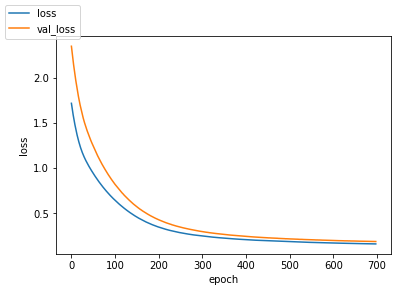

In [9]:
#best params:
#Latent_dim:  50 L2 Regularizer:  0.0
#Final Val Loss: 0.14
#optimizer Adam
#batch size 100
#initial rate 0.0001
#drop 0.5
#epochs drop 50
reg_vals = [0.0]
optimizers = ['Adam']
val_results = []
batch_size = [100]
ndims = [50]
losses = [MeanSquaredError()]
for loss in losses:
    for ndim in ndims:
        for reg_val in reg_vals:
            for optimizer in optimizers:
                for batch in batch_size:
                    for i in range(0,1):
                        print('v.',i,'Latent_dim: ',ndim,'L2 Regularizer: ', reg_val,'Optimizer:',optimizer, 'Batch size:',batch)


                        t_start = time.time()
                        LATENT_DIM = ndim
                        BATCH_SIZE = batch
                        EPOCHS = 1000

                        lrate = LearningRateScheduler(step_decay)
                        model = Sequential()
                        model.add(GRU(LATENT_DIM,return_sequences=True, input_shape=(T, 2), kernel_regularizer=l2(reg_val), recurrent_regularizer=l2(reg_val), bias_regularizer=l2(reg_val)))
                        model.add(GRU(LATENT_DIM,return_sequences=True, kernel_regularizer=l2(reg_val), recurrent_regularizer=l2(reg_val), bias_regularizer=l2(reg_val)))
                        model.add(GRU(LATENT_DIM, kernel_regularizer=l2(reg_val), recurrent_regularizer=l2(reg_val), bias_regularizer=l2(reg_val)))
                        #model.add(LSTM(32, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
                        model.add(Dense(HORIZON))
                        model.compile(optimizer=optimizer, loss=my_loss_fn, 
                                     # metrics=['accuracy']
                                     )

                        earlystop = EarlyStopping(monitor="val_loss", min_delta=0.0, patience=5)
                        model_history = model.fit(
                        train_input["X"],
                        train_input["target"],
                        batch_size=BATCH_SIZE,
                        epochs=EPOCHS,
                        validation_data=(valid_inputs["X"], valid_inputs["target"]),
                        callbacks=[earlystop, lrate],
                        verbose=1,
                        )
                        
                        # list all data in history
                        #print(model_history.history.keys())
                        total_time = time.time()-t_start
                        #make a model picture
                        model.summary()
                        #model_vis = visualizer(model, format='png', view=True)
                        model_vis = plot_model(model, to_file='model.png')
                        # summarize history for loss
                        fig, ax = plt.subplots()
                        ax.plot(model_history.history['loss'])
                        ax.plot(model_history.history['val_loss'])

                        ax.set_ylabel('loss')
                        ax.set_xlabel('epoch')
                        fig.legend(['loss', 'val_loss'], loc='upper left')
                        #plt.show()
                        print('\tFinal Val Loss:',model_history.history['val_loss'][-1],' in: {}s'.format(total_time))
                        if(model_history.history['val_loss'][-1] < 1.0):
                            val_results.append((ndim,reg_val,model_history.history['val_loss'][-1],optimizer,total_time,batch,fig,model_vis))
                        else:
                            plt.close()

In [10]:
#for result in val_results:
  #  print("ndim: ",result[0])
  #  print("reg_val: ",result[1])
  #  print("val_loss: ",result[2])
  #  print("optimizer: ",result[3])
df_results = pd.DataFrame(val_results, columns=['hidden_dimensions','L2_reg_val','final_val_loss','optimizer','training_time','batch_size','FIG','MODEL_VIS'])
res_grps = df_results.groupby('batch_size')
for batch in batch_size:
    print('Batch size: {}'.format(batch))
    df_batch = res_grps.get_group(batch).drop(['batch_size','hidden_dimensions','L2_reg_val'],axis=1)
    print('\tAvg final val loss: {:.2f}+-{:.2f}'.format(df_batch.final_val_loss.mean(),df_batch.final_val_loss.std()))
    print('\tAvg training time: {:.2f}+-{:.2f}'.format(df_batch.training_time.mean(),df_batch.training_time.std()))
    
for count,result in enumerate(val_results):
    result[-1].savefig('loss-curve_batch-size_{}_{}.png'.format(result[-4],count))

Batch size: 100
	Avg final val loss: 0.19+-nan
	Avg training time: 291.15+-nan


AttributeError: 'NoneType' object has no attribute 'savefig'

In [11]:
df_results

,hidden_dimensions,L2_reg_val,final_val_loss,optimizer,training_time,batch_size,FIG,MODEL_VIS
0,50,0.0,0.186263,Adam,291.154567,100,Figure(432x288),None


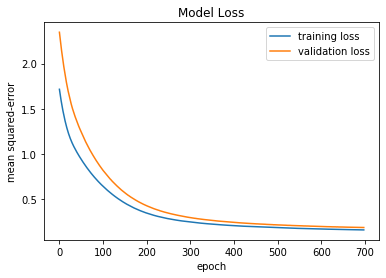

In [12]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('mean squared-error')
plt.xlabel('epoch')
plt.legend(['training loss', 'validation loss'], loc='upper right')
plt.show()

In [13]:
#now we'll test
data_test_inputs = TimeSeriesTensor(test, "p2", HORIZON, tensor_structure)
#print(data_test_inputs['X'][0])
#print(data_test_inputs['target'][0])

predictions = model.predict(data_test_inputs["X"])
#print(predictions)
ev_data = create_evaluation_df(predictions, data_test_inputs, HORIZON, y_scaler)
ev_groups = ev_data.groupby('h')
#test.head()
gr1 = ev_groups.get_group('t+1')

In [14]:
gr1.describe()

,prediction,actual
count,829.000000,829.000000
mean,-0.000043,0.000026
std,0.000104,0.000118
min,-0.000368,-0.000294
25%,-0.000104,-0.000051
50%,-0.000040,0.000024
75%,0.000020,0.000095
max,0.000448,0.000717


In [15]:
apes = []
for i in range(0, gr1.prediction.count()):
    if gr1.actual.iloc[i] == 0:
        continue
    ape = abs((gr1.prediction.iloc[i] - gr1.actual.iloc[i]) / gr1.actual.iloc[i])
    apes.append(ape)
    
mape1 = (sum(apes) / len(apes))

print('Evaluating GRU')
print("MAPE prediction 1 hour  ahead: {:.2%}".format(mape1))

Evaluating GRU
MAPE prediction 1 hour  ahead: 1324.76%


/home/rusack/evans908/.local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/rusack/evans908/.local/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/rusack/evans908/.local/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


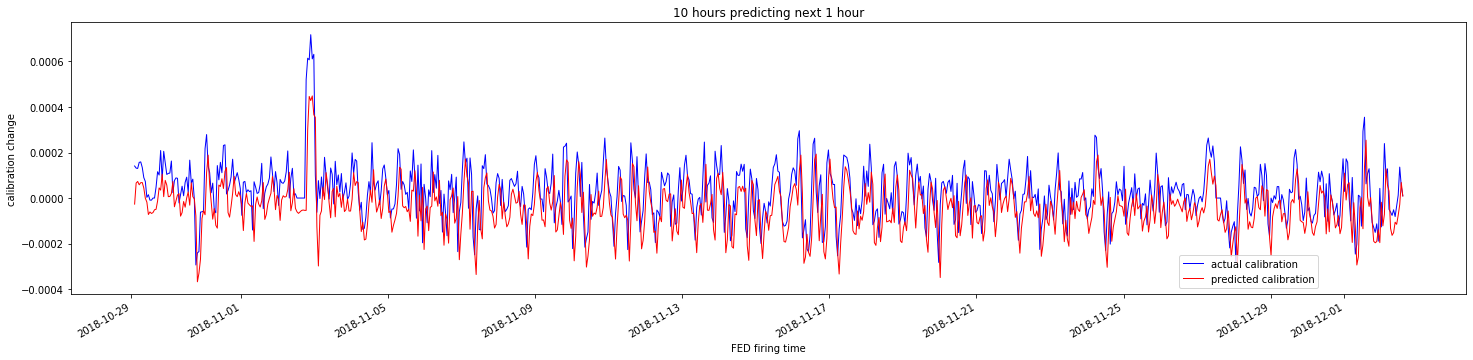

In [16]:
#lets plot our results
fig, ax = plt.subplots(figsize=(25,5))

ev_group = ev_groups.get_group('t+1')

ax.set_title('{time:.0f} hours predicting next 1 hour'.format(time=T))
ax.set_ylabel('calibration change')
ax.set_xlabel('FED firing time')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')

ax.plot(ev_group.timestamp, ev_group.actual, 
         label='actual calibration', color='blue', linewidth=1, linestyle='solid')

ax.plot(ev_group.timestamp, ev_group.prediction, 
         label='predicted calibration', color='red', linewidth=1, linestyle='solid')
#legend
fig.legend(ncol=1, loc = (0.8,0.2))
fig.show()

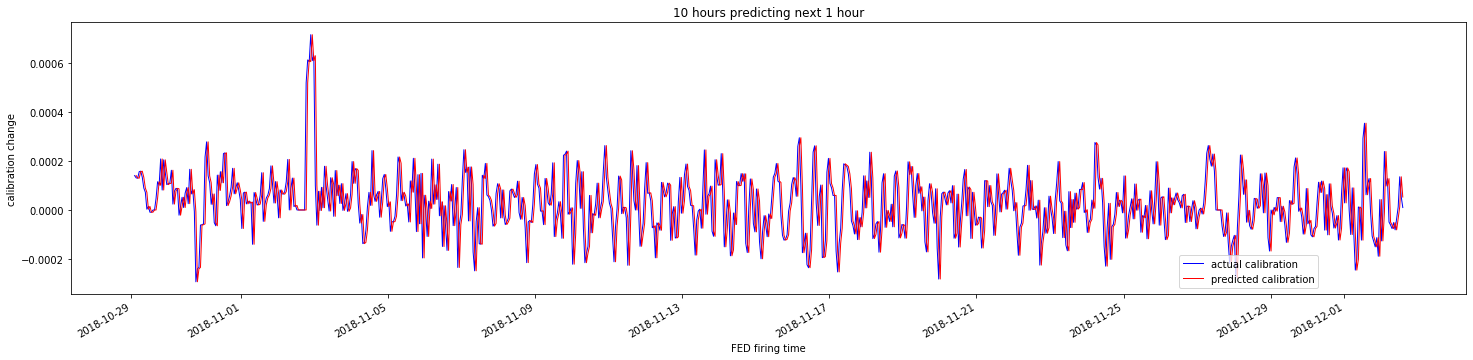

In [17]:
#lets look at a persistance model

fig, ax = plt.subplots(figsize=(25,5))

ev_group = ev_groups.get_group('t+1')
ev_group = ev_group.set_index('timestamp')

persistance = ev_group.shift()

ax.set_title('{time:.0f} hours predicting next 1 hour'.format(time=T))
ax.set_ylabel('calibration change')
ax.set_xlabel('FED firing time')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')

ax.plot(ev_group.index, ev_group.actual, 
         label='actual calibration', color='blue', linewidth=1, linestyle='solid')

ax.plot(persistance.index, persistance.actual, 
         label='predicted calibration', color='red', linewidth=1, linestyle='solid')
#legend
fig.legend(ncol=1, loc = (0.8,0.2))
fig.show()

timestamp
2018-10-29 02:19:59         NaN
2018-10-29 03:19:59    0.070077
2018-10-29 04:19:59    0.011481
2018-10-29 05:19:59    0.170502
2018-10-29 06:19:59    0.012650
                         ...   
2018-12-02 10:19:59    1.301959
2018-12-02 11:19:59    3.815839
2018-12-02 12:19:59    0.907678
2018-12-02 13:19:59    1.562243
2018-12-02 14:19:59    4.309035
Name: actual, Length: 829, dtype: float64


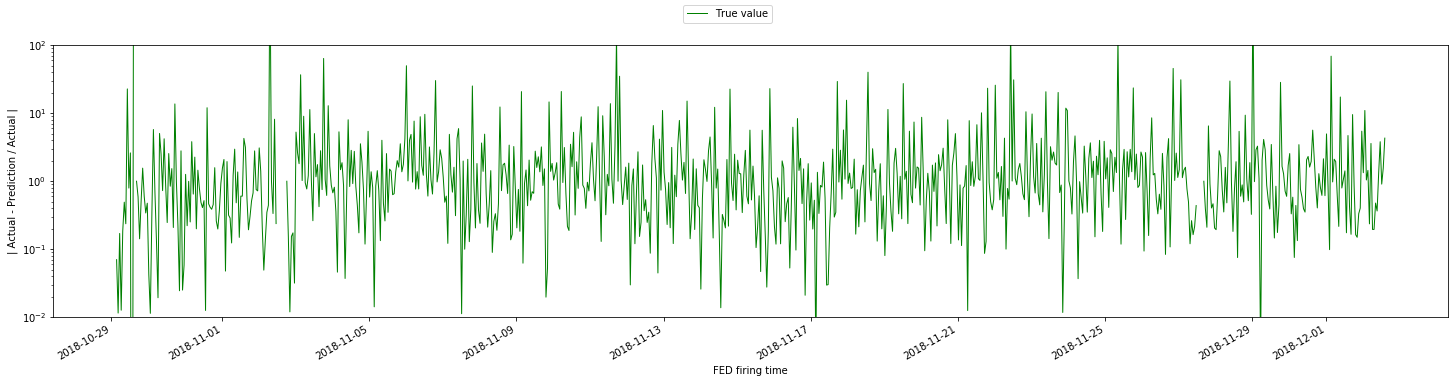

In [18]:
####MAKE DIFF PLOT FOR PERSISTANCE########
apdiff_series = ((ev_group.actual - persistance.actual) / ev_group.actual).abs()
print(apdiff_series)
fig3, ax3 = plt.subplots(figsize=(25,5))

ax3.set_ylabel('| Actual - Prediction / Actual |')
ax3.set_xlabel('FED firing time')
plt.setp(ax3.get_xticklabels(), rotation=30, horizontalalignment='right')
ax3.set_yscale('log')
ax3.set_ylim((.01,100.))
#actual data
ax3.plot(persistance.index, apdiff_series, 
     label='True value', color='green', linewidth=1, linestyle='solid')
#legend
fig3.legend(ncol=3, loc = 'upper center')


In [19]:
apes = []
for i in range(0, persistance.actual.count()):
    if gr1.actual.iloc[i] == 0:
        continue
    ape = abs((persistance.actual.iloc[i] - gr1.actual.iloc[i]) / gr1.actual.iloc[i])
    if np.isnan(ape):
        continue
    apes.append(ape)
    
mape1 = (sum(apes) / len(apes))

print('Evaluating GRU')
print("MAPE prediction 1 hour  ahead: {:.2%}".format(mape1))

Evaluating GRU
MAPE prediction 1 hour  ahead: 724.26%


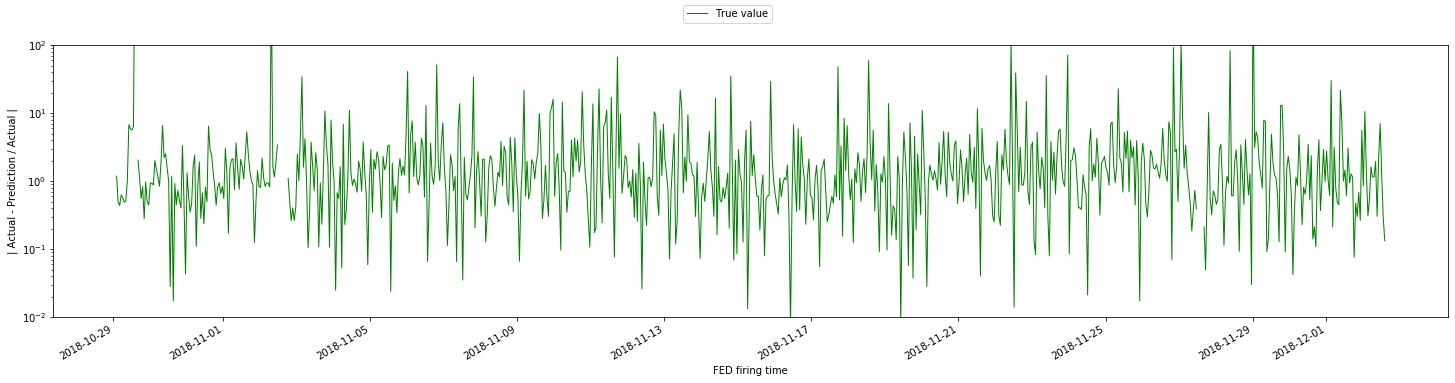

In [20]:
####MAKE DIFF PLOT########
apdiff_series = ((ev_group.actual - ev_group.prediction) / ev_group.actual).abs()
fig3, ax3 = plt.subplots(figsize=(25,5))

ax3.set_ylabel('| Actual - Prediction / Actual |')
ax3.set_xlabel('FED firing time')
plt.setp(ax3.get_xticklabels(), rotation=30, horizontalalignment='right')
ax3.set_yscale('log')
ax3.set_ylim((.01,100.))
#actual data
ax3.plot(ev_group.index, apdiff_series, 
     label='True value', color='green', linewidth=1, linestyle='solid')
#legend
fig3.legend(ncol=3, loc = 'upper center')


In [21]:
#our data is transformed to feed into the model. The diff step transforms the data by removing the large scale trends. We'll run that in reverse to look at the data with the trends.
ev_data_int = ev_data.copy()
ev_data_int['prediction'] = ev_data_int['prediction'].cumsum()
ev_data_int['actual'] = ev_data_int['actual'].cumsum()
ev_data.head()

,timestamp,h,prediction,actual
0,2018-10-29 02:19:59,t+1,-0.000027,0.000141
1,2018-10-29 03:19:59,t+1,0.000066,0.000131
2,2018-10-29 04:19:59,t+1,0.000073,0.000130
3,2018-10-29 05:19:59,t+1,0.000058,0.000157
4,2018-10-29 06:19:59,t+1,0.000067,0.000159


/home/rusack/evans908/.local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/rusack/evans908/.local/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/rusack/evans908/.local/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


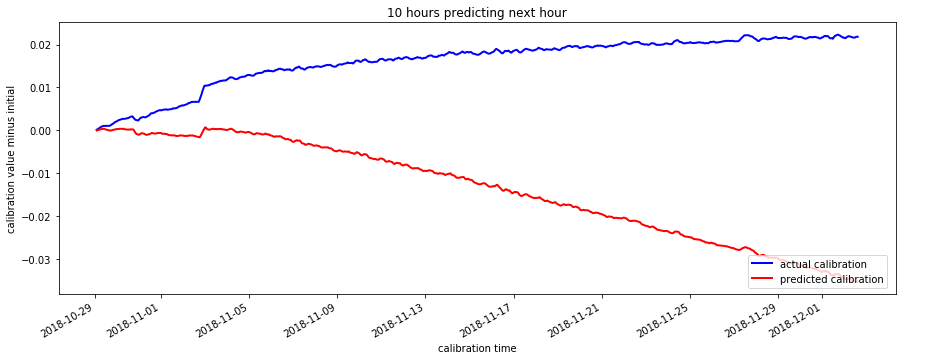

In [22]:
#lets plot our results
fig10, ax13 = plt.subplots(figsize=(15,5))

ax13.set_title('{time:.0f} hours predicting next hour'.format(time=T))
ax13.set_ylabel('calibration value minus initial')
ax13.set_xlabel('calibration time')
plt.setp(ax13.get_xticklabels(), rotation=30, horizontalalignment='right')

ax13.plot(ev_data_int.timestamp, ev_data_int.actual, 
         label='actual calibration', color='blue', linewidth=2, linestyle='solid')

ax13.plot(ev_data_int.timestamp, ev_data_int.prediction, 
         label='predicted calibration', color='red', linewidth=2, linestyle='solid')

#lumi data on alternate y axis
#ax14 = ax13.twinx()
#ax14.set_ylabel('integrated luminosity (/ub)')
#
#ax14.plot(test_lumi_avg.index, test_lumi_avg, 
#         label='lumi averaged', color='limegreen', linewidth=1, linestyle='dashed')

#legend
fig10.legend(ncol=1, loc=(0.8,0.2))
#plt.ylim([-.05, ev_data_int.actual.max()*1.1])
fig10.show()

In [23]:
apes = []
for i in range(0, gr1.prediction.count()):
    if gr1.actual.iloc[i] == 0:
        continue
    ape = abs((gr1.prediction.iloc[i] - gr1.actual.iloc[i]) / gr1.actual.iloc[i])
    apes.append(ape)
    
mape1 = (sum(apes) / len(apes))
mape1

13.247623018480903